In [1]:
import datetime
import pickle

import pandas as pd
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import segregation
from libpysal.weights.distance import DistanceBand
from esda.moran import Moran_Local, Moran

/home/h9b/GIT_REPOS/global-urban-building-completeness-analysis/venv/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
def get_urban_centers_gdf_timeline(region, month):
    
    if month.year == 2022:
        column_b = 'prediction_osm_completeness'
    else:
        column_b = f'prediction_osm_completeness_{month.year}'

    gdf = gpd.read_file(
        "../data/global_urban_building_completeness.gpkg",
        layer='rf_adjusted_prediction_reference_and_osm_urban_centers_centroid',
    )

    
    gdf["osm_completeness"] = gdf[column_b]
    gdf.rename(columns={column_b: "prediction_osm_completeness"}, inplace=True)
    gdf.loc[gdf['sum_prediction_sqkm'] < 0, 'sum_prediction_sqkm'] = 0
    gdf.loc[gdf['osm_completeness'] < 0, 'osm_completeness'] = 0
    gdf.loc[gdf['osm_completeness'] > 1, 'osm_completeness'] = 1
    gdf = gdf.loc[gdf["region_wb"].isin(region)]
    gdf["sum_osm_building_area_sqkm"] = gdf["sum_prediction_sqkm"] * gdf["osm_completeness"]
    
    print(len(gdf))
    
    all_columns = gdf.columns
    include_fields=[
        "urban_center_id", "region_wb", "ghspop", "sum_prediction_sqkm",
        "prediction_osm_completeness", "sum_osm_building_area_sqkm", "osm_completeness",
        "geometry"
    ]
    columns_to_drop = list(set(all_columns) - set(include_fields))    
    gdf.drop(
        columns_to_drop,
        axis=1,
        inplace=True
    )
    
    gdf.dropna(inplace=True)
    print(len(gdf))
    
    print(f"got {len(gdf)} samples")
    return gdf

## Configuration and Styles

In [3]:
model_name = "rf_adjusted"
training_data = "reference_and_osm"

wb_regions = [
    ["East Asia & Pacific"],
    ["Europe & Central Asia"],
    ["Latin America & Caribbean"],
    ["Middle East & North Africa"],
    ["North America"],
    ["South Asia"],
    ["Sub-Saharan Africa"],
    [
        "Europe & Central Asia", 
        "Latin America & Caribbean", 
        "North America", 
        "East Asia & Pacific", 
        "South Asia", 
        "Middle East & North Africa",
        "Sub-Saharan Africa"
    ],
]

linestyles = [
    ('dotted',                (0, (1, 1))),
    ('densely dashed',        (0, (5, 1))),
    ('densely dashed',        (0, (5, 1))),
    ('solid',                 (0, ())),
    ('dotted',                (0, (1, 1))),
    ('solid',                 (0, ())),
    ('densely dashed',        (0, (5, 1))),
    ('solid',                 (0, ())),
]

label_strings = [
    "East Asia & Pacific",
    "Europe & Central Asia",
    "Latin America & Caribbean",
    "Middle East & North Africa",
    "North America",
    "South Asia",
    "Sub-Saharan Africa",
    "all"
]

cmap = matplotlib.cm.get_cmap('tab10')
colors_dict = {
    "East Asia & Pacific": cmap(0),
    "Europe & Central Asia": cmap(0.125),
    "Latin America & Caribbean": cmap(0.25),
    "Middle East & North Africa": cmap(0.375),
    "North America": cmap(0.5),
    "South Asia": cmap(0.625),
    "Sub-Saharan Africa": cmap(0.75),
    "all": "black",
}


all_months = [
    datetime.date(2008, 1, 1),
    datetime.date(2009, 1, 1),
    datetime.date(2010, 1, 1),
    datetime.date(2011, 1, 1),
    datetime.date(2012, 1, 1),
    datetime.date(2013, 1, 1),
    datetime.date(2014, 1, 1),
    datetime.date(2015, 1, 1),
    datetime.date(2016, 1, 1),
    datetime.date(2017, 1, 1),
    datetime.date(2018, 1, 1),
    datetime.date(2019, 1, 1),
    datetime.date(2020, 1, 1),
    datetime.date(2021, 1, 1),
    datetime.date(2022, 1, 1)
]

## Calculate Moran's I and Gini Coefficient

In [50]:
morans_lists = {}
gini_lists = {}
pop_low_completeness_lists = {}
pop_high_completeness_lists = {}
avg_completeness_lists = {}

for i, region in enumerate(wb_regions):
    
    morans_lists[i] = []
    gini_lists[i] = []
    pop_low_completeness_lists[i] = []
    pop_high_completeness_lists[i] = []
    avg_completeness_lists[i] = []
    
    for j, month in enumerate(all_months):
        print(month)
        
        df = get_urban_centers_gdf_timeline(
            region,
            month,
        ).reset_index()
        
        avg_completeness_lists[i].append(
            df["prediction_osm_completeness"].mean()
        )
        
        index = segregation.singlegroup.gini.Gini(
            df[['sum_osm_building_area_sqkm', 'sum_prediction_sqkm']],
            'sum_osm_building_area_sqkm',
            'sum_prediction_sqkm'
        )
        gini_lists[i].append(index.statistic)

        w = DistanceBand.from_dataframe(df, 5, binary=False)
        w.transform = 'r'

        df = df.loc[~df.index.isin(w.islands)]

        w = DistanceBand.from_dataframe(df, 5, binary=False)
        w.transform = 'r'

        y = df['osm_completeness']
        # global and local Moran's I
        try:
            moran_global = Moran(y, w)
            moran_loc = Moran_Local(y, w)
            df[f"{month.year}_moran_loc"] = moran_loc.Is
            df[f"{month.year}_moran_loc_q"] = moran_loc.q
            df[f"{month.year}_moran_loc_p_sim"] = moran_loc.p_sim
            df[f"{month.year}_moran_global"] = moran_global.I
        except (ZeroDivisionError, StopIteration):
            df[f"{month.year}_moran_loc"] = np.nan
            df[f"{month.year}_moran_global"] = np.nan

        morans_lists[i].append(moran_global.I)

        pop_low_completeness = df.loc[df['osm_completeness'] < 0.2]["ghspop"].sum() / df["ghspop"].sum()
        pop_low_completeness_lists[i].append(pop_low_completeness)

        pop_high_completeness = df.loc[df['osm_completeness'] >= 0.8]["ghspop"].sum() / df["ghspop"].sum()
        pop_high_completeness_lists[i].append(pop_high_completeness)

2008-01-01
3068
2975
got 2975 samples
('WARNING: ', 2677, ' is an island (no neighbors)')
('WARNING: ', 2735, ' is an island (no neighbors)')
('WARNING: ', 2916, ' is an island (no neighbors)')
('WARNING: ', 2935, ' is an island (no neighbors)')
2009-01-01
3068
2975
got 2975 samples
('WARNING: ', 2677, ' is an island (no neighbors)')
('WARNING: ', 2735, ' is an island (no neighbors)')
('WARNING: ', 2916, ' is an island (no neighbors)')
('WARNING: ', 2935, ' is an island (no neighbors)')
2010-01-01
3068
2975
got 2975 samples
('WARNING: ', 2677, ' is an island (no neighbors)')
('WARNING: ', 2735, ' is an island (no neighbors)')
('WARNING: ', 2916, ' is an island (no neighbors)')
('WARNING: ', 2935, ' is an island (no neighbors)')
2011-01-01
3068
2975
got 2975 samples
('WARNING: ', 2677, ' is an island (no neighbors)')
('WARNING: ', 2735, ' is an island (no neighbors)')
('WARNING: ', 2916, ' is an island (no neighbors)')
('WARNING: ', 2935, ' is an island (no neighbors)')
2012-01-01
3068


2015-01-01
1351
1351
got 1351 samples
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 8, ' is an island (no neighbors)')
('WARNING: ', 675, ' is an island (no neighbors)')
('WARNING: ', 1153, ' is an island (no neighbors)')
('WARNING: ', 1158, ' is an island (no neighbors)')
('WARNING: ', 1161, ' is an island (no neighbors)')
('WARNING: ', 1168, ' is an island (no neighbors)')
('WARNING: ', 1307, ' is an island (no neighbors)')
('WARNING: ', 1308, ' is an island (no neighbors)')
('WARNING: ', 1309, ' is an island (no neighbors)')
('WARNING: ', 1310, ' is an island (no neighbors)')
('WARNING: ', 1317, ' is an island (no neighbors)')
('WARNING: ', 1318, ' is an island (no neighbors)')
2016-01-01
1351
1351
got 1351 samples
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 8, ' is an island (no neighbors)')
('WARNING: ', 675, ' is an island (no neighbors)')
('WARNING: ', 1153, ' is an island (no neighbors)')
('WARNING: ', 1158, ' is an island (no neighbors)')
('

2016-01-01
378
376
got 376 samples
('WARNING: ', 365, ' is an island (no neighbors)')
2017-01-01
378
376
got 376 samples
('WARNING: ', 365, ' is an island (no neighbors)')
2018-01-01
378
376
got 376 samples
('WARNING: ', 365, ' is an island (no neighbors)')
2019-01-01
378
376
got 376 samples
('WARNING: ', 365, ' is an island (no neighbors)')
2020-01-01
378
376
got 376 samples
('WARNING: ', 365, ' is an island (no neighbors)')
2021-01-01
378
376
got 376 samples
('WARNING: ', 365, ' is an island (no neighbors)')
2022-01-01
378
376
got 376 samples
('WARNING: ', 365, ' is an island (no neighbors)')
2008-01-01
3997
3996
got 3996 samples
('WARNING: ', 3987, ' is an island (no neighbors)')
2009-01-01
3997
3996
got 3996 samples
('WARNING: ', 3987, ' is an island (no neighbors)')
2010-01-01
3997
3996
got 3996 samples
('WARNING: ', 3987, ' is an island (no neighbors)')
2011-01-01
3997
3996
got 3996 samples
('WARNING: ', 3987, ' is an island (no neighbors)')
2012-01-01
3997
3996
got 3996 samples


('WARNING: ', 9050, ' is an island (no neighbors)')
('WARNING: ', 10671, ' is an island (no neighbors)')
('WARNING: ', 12564, ' is an island (no neighbors)')
('WARNING: ', 12715, ' is an island (no neighbors)')
('WARNING: ', 12773, ' is an island (no neighbors)')
('WARNING: ', 12954, ' is an island (no neighbors)')
('WARNING: ', 12988, ' is an island (no neighbors)')
('WARNING: ', 12989, ' is an island (no neighbors)')
2015-01-01
13189
13090
got 13090 samples
('WARNING: ', 1347, ' is an island (no neighbors)')
('WARNING: ', 1487, ' is an island (no neighbors)')
('WARNING: ', 3276, ' is an island (no neighbors)')
('WARNING: ', 5609, ' is an island (no neighbors)')
('WARNING: ', 5745, ' is an island (no neighbors)')
('WARNING: ', 5832, ' is an island (no neighbors)')
('WARNING: ', 9050, ' is an island (no neighbors)')
('WARNING: ', 10671, ' is an island (no neighbors)')
('WARNING: ', 12564, ' is an island (no neighbors)')
('WARNING: ', 12715, ' is an island (no neighbors)')
('WARNING: ',

## Save Results

In [53]:
outfile = "../data/inequality_stats_data.pkl"

stats = []
for i, region in enumerate(wb_regions):
    stats.append([
        label_strings[i],
        all_months,
        avg_completeness_lists[i],
        pop_low_completeness_lists[i],
        pop_high_completeness_lists[i],
        morans_lists[i],
        gini_lists[i]
    ])
    
with open(outfile, 'wb') as f:
    pickle.dump(stats, f)

## Create Plots

In [54]:
with open(outfile, 'rb') as f:
    stats_new = pickle.load(f)

columns = [
    "region",
    "months",
    "avg_completeness",
    "pop_low_completeness",
    "pop_high_completeness",
    "morans",
    "gini"
]    
    
stats_df = pd.DataFrame(
    stats_new,
    columns=columns
)
display(stats_df)

,region,months,avg_completeness,pop_low_completeness,pop_high_completeness,morans,gini
0,East Asia & Pacific,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[[0.1689887713214174, 1.4631921950456931e-05],...","[1.0, 0.9997054261876791, 0.999585521994265, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.000102490520261913...","[0.1732630498278176, 0.014505016582332489, 0.0...","[0.9739591221968579, 0.9240396771477459, 0.902..."
1,Europe & Central Asia,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[[0.6726871744108959, 0.001142515456060093], [...","[1.0, 0.9723812946358942, 0.8519740407436711, ...","[0.0, 0.0032120690144774268, 0.006545874205147...","[0.08719318722463147, 0.09601657797549965, 0.2...","[0.8947386291877156, 0.8262487180254977, 0.783..."
2,Latin America & Caribbean,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[[0.16590365725343537, 3.1385899941354993e-06]...","[1.0, 1.0, 1.0, 0.9969865342646616, 0.99613298...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.000469243271445667...","[-0.0007502721747384874, -0.003991561295434502...","[0.9678515822787538, 0.8870352477895302, 0.785..."
3,Middle East & North Africa,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[[0.10741625496929318, 8.356289973610676e-06],...","[1.0, 1.0, 1.0, 0.9997522325550188, 0.99604705...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00078428...","[-0.0008548440433375861, 0.04083317055731736, ...","[0.954779410267433, 0.9088902442896059, 0.8372..."
4,North America,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[[0.5660847959535437, 0.0003411706758773644], ...","[1.0, 1.0, 0.9295452628741798, 0.9053208095462...","[0.0, 0.0, 0.0, 0.0022861645073635264, 0.00228...","[0.09339538142036623, 0.0693266790876817, 0.08...","[0.9555950044687547, 0.7330545914199136, 0.735..."
5,South Asia,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[[0.0739131970238663, 1.5613356729314755e-07],...","[1.0, 1.0, 1.0, 1.0, 0.9998817957452338, 0.999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.5351125822844...","[-0.00018690207438500623, 0.006979220974870457...","[0.9994527987830524, 0.9187462771842313, 0.866..."
6,Sub-Saharan Africa,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[[0.24075428927381376, 5.058060589483473e-06],...","[1.0, 1.0, 1.0, 1.0, 0.998859977198405, 0.9835...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.000825779801253324...","[-0.000531607587616004, 0.0018492791944708731,...","[0.9834930433612509, 0.9125312531813081, 0.889..."
7,all,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[[0.21214889641109394, 0.00013285675100471476]...","[1.0, 0.9970352561076592, 0.9809374740131177, ...","[0.0, 0.000335105963613671, 0.0006829123139394...","[0.11348733620164775, 0.13424700288514954, 0.3...","[0.9727744227280896, 0.9343761258343939, 0.916..."


0.3145852485759984 0.3145436546868554 0.3145436546868554


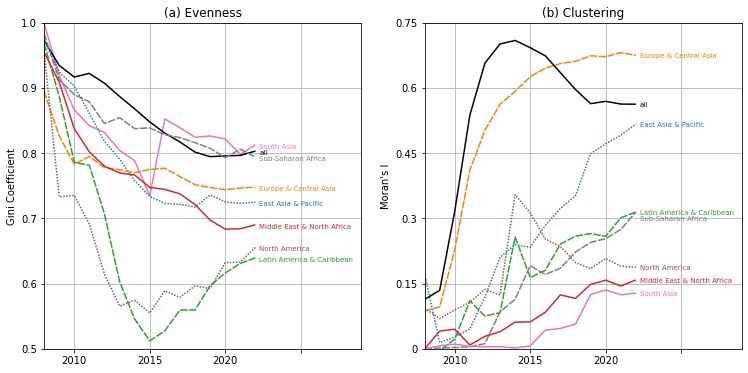

In [55]:
fontsize = 7

fig, axs = plt.subplots(1, 2, figsize=(12.5, 6))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=0.2, hspace=0.2) # set the spacing between axes.

max_y_values = {
    "gini": [],
    "morans": []
}

columns = [
    "gini",
    "morans"
]


cmap = matplotlib.cm.get_cmap('tab10')
colors_dict = {
    "East Asia & Pacific": cmap(0),
    "Europe & Central Asia": cmap(0.125),
    "Latin America & Caribbean": cmap(0.25),
    "Middle East & North Africa": cmap(0.375),
    "North America": cmap(0.5),
    "South Asia": cmap(0.625),
    "Sub-Saharan Africa": cmap(0.75),
    "all": "black",
}

linestyles_dict = {
    "East Asia & Pacific": ('dotted', (0, (1, 1))),
    "Europe & Central Asia": ('densely dashed', (0, (5, 1))),
    "Latin America & Caribbean": ('densely dashed', (0, (5, 1))),
    "Middle East & North Africa": ('solid', (0, ())),
    "North America": ('dotted', (0, (1, 1))),
    "South Asia": ('solid',(0, ())),
    "Sub-Saharan Africa": ('densely dashed', (0, (5, 1))),
    "all":  ('solid', (0, ())),
}
    

label_strings_new = {
    "gini": [
        "South Asia",
        "all",
        "Sub-Saharan Africa",
        "East Asia & Pacific",
        "Europe & Central Asia",
        "Latin America & Caribbean",
        "Middle East & North Africa",
        "North America",
    ],
    "morans": [
        "Europe & Central Asia",
        "all",
        "East Asia & Pacific",
        "Latin America & Caribbean",
        "Sub-Saharan Africa",
        "North America",
        "Middle East & North Africa",
        "South Asia",
    ]
}

for j, column in enumerate(columns):
    ax = plt.subplot(gs1[j])
    
    for i, region in enumerate(label_strings_new[column]):
        region_df = stats_df.loc[stats_df["region"] == region]

        max_y_values[column].append(
            region_df[column].to_list()[0][-1]
        )

        ax.plot(
            region_df["months"].to_list()[0],
            region_df[column].to_list()[0],
            label=region,
            color=colors_dict[region],
            linestyle=linestyles_dict[region][1]
        )

        if i == 0:
            label_position = max_y_values[column][i]
        elif abs(max_y_values[column][i-1] - max_y_values[column][i]) < 0.0075:
            print(max_y_values[column][i], max_y_values[column][i-1], label_position)
            label_position = float(max_y_values[column][i]) - 0.015
        else:
            label_position = max_y_values[column][i]

        ax.annotate(
            region,
            (datetime.date(2022, 4, 1), label_position - 0.005),
            fontsize=fontsize,
            color=colors_dict[region]
        )
    
ax = plt.subplot(gs1[0])
ax1 = plt.subplot(gs1[1])  

ax.set_title("(a) Evenness")
ax.set_ylabel("Gini Coefficient")
ax.set_xlim([datetime.date(2008, 1, 1), datetime.date(2029, 1, 1)])
ax.set_ylim([0.5,1.0])
ax.set_xticks([
    datetime.date(2010, 1, 1),
    datetime.date(2015, 1, 1),
    datetime.date(2020, 1, 1),
    datetime.date(2025, 1, 1),
])
ax.set_xticklabels(["2010", "2015", "2020", ""])
ax.grid()

ax1.set_title("(b) Clustering")
ax1.set_ylabel("Moran's I")
ax1.set_xlim([datetime.date(2008, 1, 1), datetime.date(2029, 1, 1)])
ax1.grid()
ax1.set_xticks([
    datetime.date(2010, 1, 1),
    datetime.date(2015, 1, 1),
    datetime.date(2020, 1, 1),
    datetime.date(2025, 1, 1),
])
ax1.set_xticklabels(["2010", "2015", "2020", ""])
ax1.set_yticks([
    0, 0.15, 0.30, 0.45, 0.6, 0.75
])
ax1.set_yticklabels([0, 0.15, 0.30, 0.45, 0.6, 0.75])
ax1.set_ylim([0,0.75])


plt.savefig(
    f"../figures/completeness_inequality_per_month_by_region_{model_name}.png",
    dpi=300,
    bbox_inches = 'tight',
    pad_inches = 0.25
)

plt.show()  

## Get Data for Europe & Central Asia and Sub-Saharan Africa

In [4]:
wb_regions = [
    ["East Asia & Pacific"],
    ["Europe & Central Asia"],
    ["Latin America & Caribbean"],
    ["Middle East & North Africa"],
    ["North America"],
    ["South Asia"],
    ["Sub-Saharan Africa"],
    [
        "Europe & Central Asia", 
        "Latin America & Caribbean", 
        "North America", 
        "East Asia & Pacific", 
        "South Asia", 
        "Middle East & North Africa",
        "Sub-Saharan Africa"
    ],
]


all_months = [
    datetime.date(2010, 1, 1),
    datetime.date(2014, 1, 1),
    datetime.date(2022, 1, 1),
]

colors = [
    "blue",
    "green",
    "yellow",
    "violet"
]

column = "osm_completeness"

for j, region_id in enumerate([1, 6]):
    region = wb_regions[region_id]
    
    for i, month in enumerate(all_months):
        
        # need to make sure to reset index!
        df = get_urban_centers_gdf_timeline(
            region,
            month
        )
        df.drop(["prediction_osm_completeness"], axis=1, inplace=True)
        
        index = segregation.singlegroup.gini.Gini(
            df[['sum_osm_building_area_sqkm', 'sum_prediction_sqkm']],
            'sum_osm_building_area_sqkm',
            'sum_prediction_sqkm'
        )
        gini = index.statistic
        
        df.reset_index(inplace=True)
        
        w = DistanceBand.from_dataframe(df, 5, binary=False)
        w.transform = 'r'

        df = df.loc[~df.index.isin(w.islands)]
        w = DistanceBand.from_dataframe(df, 5, binary=False)
        w.transform = 'r'

        y = df[column]
        # global and local Moran's I
        try:
            moran_global = Moran(y, w)
            moran_loc = Moran_Local(y, w)
            df[f"{column}_moran_loc"] = moran_loc.Is
            df[f"{column}_moran_loc_q"] = moran_loc.q
            df[f"{column}_moran_loc_p_sim"] = moran_loc.p_sim
            df[f"{column}_moran_global"] = moran_global.I
        except (ZeroDivisionError, StopIteration):
            df[f"{column}_moran_loc"] = np.nan
            df[f"{column}_moran_global"] = np.nan

        morans = moran_global.I

        print(region, month, gini, morans)

        df["alpha"] = 0.2
        df.loc[df["osm_completeness_moran_loc_p_sim"] < 0.1, "alpha"] = 1
        df.to_file(
            "../data/global_urban_building_completeness.gpkg",
            layer=f'{region[0]}_{month}',
            driver="GPKG"
        )

1351
1351
got 1351 samples
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 8, ' is an island (no neighbors)')
('WARNING: ', 675, ' is an island (no neighbors)')
('WARNING: ', 1153, ' is an island (no neighbors)')
('WARNING: ', 1158, ' is an island (no neighbors)')
('WARNING: ', 1161, ' is an island (no neighbors)')
('WARNING: ', 1168, ' is an island (no neighbors)')
('WARNING: ', 1307, ' is an island (no neighbors)')
('WARNING: ', 1308, ' is an island (no neighbors)')
('WARNING: ', 1309, ' is an island (no neighbors)')
('WARNING: ', 1310, ' is an island (no neighbors)')
('WARNING: ', 1317, ' is an island (no neighbors)')
('WARNING: ', 1318, ' is an island (no neighbors)')
['Europe & Central Asia'] 2010-01-01 0.78316442074759 0.22755110412249188
1351
1351
got 1351 samples
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 8, ' is an island (no neighbors)')
('WARNING: ', 675, ' is an island (no neighbors)')
('WARNING: ', 1153, ' is an island (no neighbors)')
('